In [1]:
import pyprob
%matplotlib inline
import matplotlib.pyplot as plt
from pyprob import Model
import numpy as np

In [2]:
import math
import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform
import torch
class GaussianUnknownMean(Model):
    def __init__(self):
        super().__init__(name="Gaussian with unknown mean") # give the model a name

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) mean variable to be inferred:
        a = pyprob.sample(Uniform(0,1), name = 'input1') # NOTE: sample -> denotes latent variables
        b = pyprob.sample(Uniform(0,1.5), name = 'input2') # NOTE: sample -> denotes latent variables

        a_visible = pyprob.sample(pyprob.distributions.Categorical([0.5,0.5]))
        b_visible = pyprob.sample(pyprob.distributions.Categorical([0.5,0.5]))
        
        total_energy = a + b
        visible_energy = 0
        if a_visible == 1:
            visible_energy += a
        if b_visible == 1:
            visible_energy += b
        
        true_missing_energy = total_energy - visible_energy
        missing_energy = pyprob.sample(pyprob.distributions.Normal(true_missing_energy, 0.05))
        
        probs = [0,1] if missing_energy > 1.2 else [1,0]
        obs_distr = pyprob.distributions.Categorical(probs)

        pyprob.observe(obs_distr, name='obs0') # NOTE: observe -> denotes observable variables
        return a,b, a_visible, b_visible, missing_energy, true_missing_energy

model = GaussianUnknownMean()

In [3]:
model.learn_inference_network(
    num_traces=10000,
    observe_embeddings={'obs0': {'dim': 32, 'depth': 3}}
)

Creating new inference network...
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Traces/sec
New layers, address: 16__forward__a__Uniform__1, distribution: Uniform
New layers, address: 36__forward__b__Uniform__1, distribution: Uniform
New layers, address: 58__forward__a_visible__Categorical(len_probs:2)__..., distribution: Categorical
New layers, address: 80__forward__b_visible__Categorical(len_probs:2)__..., distribution: Categorical
New layers, address: 152__forward__missing_energy__Normal__1, distribution: Normal
Total addresses: 5, parameters: 10,103
0d:00:00:13 | 1    | 10,048    | +1.28e-01 | -2.55e-01 | -4.43e-02 | 0d:00:00:03 | 756.0                              


In [14]:
condition  = {'obs0': 1}

prior = model.prior_distribution(
    num_traces=2000,
)
posterior = model.posterior_distribution(
    num_traces=2000,
    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
    observe=condition
)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 2000/2000 | 973.36       
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:29 | 0d:00:00:00 | #################### | 2000/2000 | 68.39       


In [22]:
a = model.posterior_traces(num_traces=10)

Time spent  | Time remain.| Progress             | Trace | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 10/10 | 893.26       


In [29]:
t = a[0]

In [48]:
import pyprob
import pyprob.diagnostics
g = pyprob.diagnostics.graph(a)
g.render_to_file('test')
!rm -rf  test.png*

In [54]:
pyprob.diagnostics.autocorrelation(a)

Loading selected variables to memory
Time spent  | Time remain.| Progress             | Traces | Traces/sec
0d:00:00:00 | 0d:00:00:00 | ##################-- | 10/10 | 8,696.46       
Computing autocorrelation for variable address: 16__forward__a__Uniform__1, name: input1 (1 of 3)
Computing autocorrelation for variable address: 36__forward__b__Uniform__1, name: input2 (2 of 3)
Computing autocorrelation for variable address: 202__forward__?__Categorical(len_probs:2)__1, name: obs0 (3 of 3)


/Users/lukasheinrich/Code/hamburl_mlhep/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/lukasheinrich/Code/hamburl_mlhep/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(array([1, 2, 3, 4, 5]),
 defaultdict(<function pyprob.diagnostics._variable_values.<locals>.<lambda>()>,
             {'16__forward__a__Uniform__1': {'variable': Variable(name:input1, control:True, replace:False, observable:True, observed:False, tagged:False, address:16__forward__a__Uniform__1, distribution:Uniform(lwo: 0.0, high: 1.0), value:tensor(0.9262): log_prob:tensor(0.)),
               'values': array([0.92623162, 0.33629417, 0.62711567, 0.17116344, 0.54734939,
                      0.09648293, 0.20527089, 0.7107901 , 0.56053537, 0.92491835]),
               'autocorrelation': array([-0.13386168,  0.34960486, -0.47844205, -0.38795516, -0.24238916])},
              '36__forward__b__Uniform__1': {'variable': Variable(name:input2, control:True, replace:False, observable:True, observed:False, tagged:False, address:36__forward__b__Uniform__1, distribution:Uniform(lwo: 0.0, high: 1.5), value:tensor(1.0302): log_prob:tensor(-0.4055)),
               'values': array([1.03022182, 0.25

In [6]:
prior     = np.asarray([[x.item() for x in prior.sample()] for x in range(1000)])
posterior = np.asarray([[x.item() for x in posterior.sample()] for x in range(1000)])

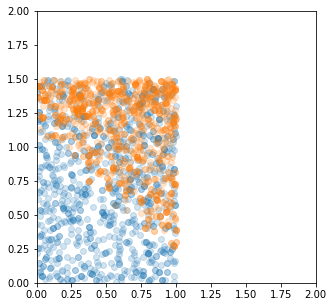

In [7]:
plt.scatter(prior[:,0],prior[:,1], alpha = 0.2)
plt.scatter(posterior[:,0],posterior[:,1], alpha = 0.2)
plt.xlim(0,2)
plt.ylim(0,2)
plt.gcf().set_size_inches(5,5)

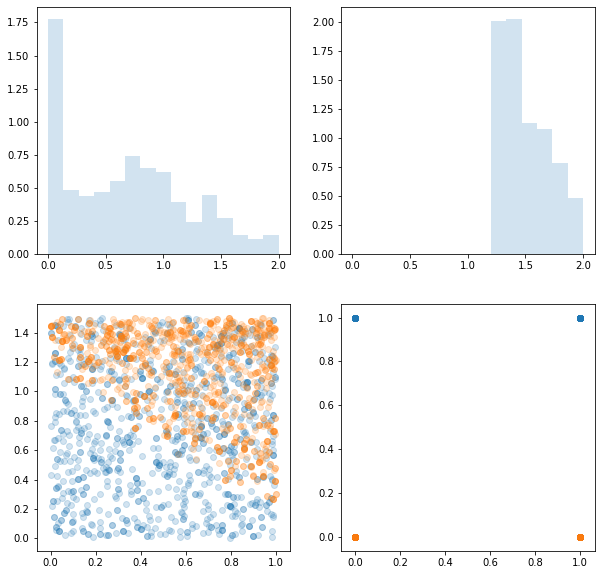

In [11]:
f, axarr = plt.subplots(2,2)
f.set_size_inches(10,10)
edges = np.linspace(0,2,16)
axarr[0,0].hist(prior[:,4], bins = edges, density = True, alpha = 0.2)
axarr[0,1].hist(posterior[:,4], bins = edges, density = True, alpha = 0.2)
# axarr[0,0].hist(prior[:,5], bins = edges, density = True, alpha = 0.2)
# axarr[0,1].hist(posterior[:,5], bins = edges, density = True, alpha = 0.2)

axarr[1,0].scatter(prior[:,0],prior[:,1], alpha = 0.2)
axarr[1,0].scatter(posterior[:,0],posterior[:,1], alpha = 0.2)


axarr[1,1].scatter(prior[:,2],prior[:,3], alpha = 0.2)
axarr[1,1].scatter(posterior[:,2],posterior[:,3], alpha = 0.2)

(array([718.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 282.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

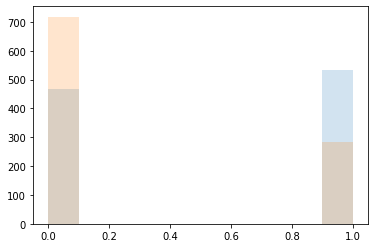

In [12]:
plt.hist(prior[:,2], alpha = 0.2)
plt.hist(posterior[:,2], alpha = 0.2)

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

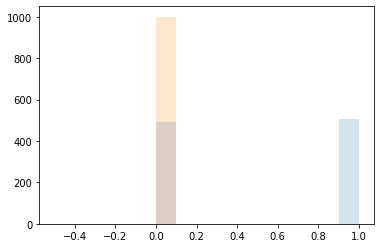

In [10]:
plt.hist(prior[:,3], alpha = 0.2)
plt.hist(posterior[:,3], alpha = 0.2)

In [13]:
posterior.

array([[0.64433187, 0.53896922, 0.        , 0.        , 1.20142996,
        1.18330109],
       [0.51560456, 1.38770759, 1.        , 0.        , 1.38200414,
        1.38770771],
       [0.95759577, 0.56876987, 0.        , 0.        , 1.57478213,
        1.52636564],
       ...,
       [0.3680523 , 1.32864809, 1.        , 0.        , 1.38536251,
        1.32864809],
       [0.65976262, 0.84378701, 0.        , 0.        , 1.5776099 ,
        1.50354958],
       [0.59493113, 0.87465703, 0.        , 0.        , 1.61129177,
        1.46958816]])